### import libraries

In [3]:
# 1. to handle the data
import pandas as pd
import numpy as np

# to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# this is for jupyter notebook to show the plot in the notebook itself instead of opening a new window
%matplotlib inline

# To preprocess the data
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
#Model
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

#Evaluation
from sklearn.metrics import roc_auc_score

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

#### Dataset Description
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Bank Customer Churn Prediction dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

#### Files
<b>train.csv</b> - the training dataset; Exited is the binary target

<b>test.csv</b> - the test dataset; your objective is to predict the probability of Exited

<b>sample_submission.csv</b> - a sample submission file in the correct format

### Basic Exploratory Data Analysis

#### Loading the Dataset

In [5]:
# Load Submission Data 
df_submission = pd.read_csv('./sample_submission.csv')
# Load test Data 
df_test = pd.read_csv('./test.csv')
# Load Train Dataset and show head of Data 
#Train Data 
df_train = pd.read_csv('./train.csv')

#### Making a Copy of the Test Data for Future Use 

In [6]:
df_test_ov = df_test.copy()
df_test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [7]:
# For Displaying Maximum Columns
pd.set_option('display.max_columns', None)

#### Quick Overview

In [8]:
df_train.head(n=3)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0


In [10]:
df_test.head(n=3)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.0,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.0,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.0,2,1.0,0.0,138882.09


In [11]:
df_submission.head(n=3)

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5


#### Shape of Datasets

In [12]:
# Checking the number of rows and columns

num_train_rows, num_train_columns = df_train.shape

num_test_rows, num_test_columns = df_test.shape

num_submission_rows, num_submission_columns = df_submission.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

print("Submission Data:")
print(f"Number of Rows: {num_submission_rows}")
print(f"Number of Columns: {num_submission_columns}")

Training Data:
Number of Rows: 165034
Number of Columns: 14

Test Data:
Number of Rows: 110023
Number of Columns: 13

Submission Data:
Number of Rows: 110023
Number of Columns: 2


#### Check for Null Values in Datasets

In [13]:
# Null Values in Train 
train_null = df_train.isnull().sum().sum()

#Null Count in Test 
test_null = df_test.isnull().sum().sum()

#null Count in Submission
submission_null = df_submission.isnull().sum().sum()

print(f'Null Count in Train: {train_null}')
print(f'Null Count in Test: {test_null}')
print(f'Null Count in Submission: {submission_null}')

Null Count in Train: 0
Null Count in Test: 0
Null Count in Submission: 0


#### Duplicates Values in Datasets

In [14]:
# Count duplicate rows in train_data
train_duplicates = df_train.duplicated().sum()

# Count duplicate rows in test_data
test_duplicates = df_test.duplicated().sum()

# Count duplicate rows in original_data
submission_duplicates = df_submission.duplicated().sum()

# Print the results
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in test_data: {submission_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in test_data: 0


### Exploring the Train Dataset

In [15]:
# Checking the number of rows and columns
num_train_rows, num_train_columns = df_train.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

Training Data:
Number of Rows: 165034
Number of Columns: 14



In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


#### Observations:

There are 165034 rows and 14 columns in the dataset.
The columns having float datatypes are 5, integer datatype 6, object datatype are 3
The data does not contain any missing values
The target variable in the dataset is Exited.

### Descriptive Analysis

In [17]:
df_train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


#### Checking The Null And Duplicate Values

In [19]:
# Null Values in Train 
train_null = df_train.isnull().sum().sum()
print(f'Null Count in Train: {train_null}')

Null Count in Train: 0


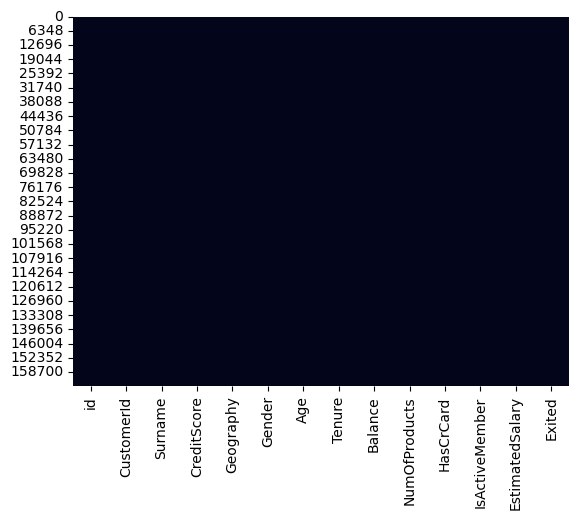

In [20]:
# visual proof 
sns.heatmap(df_train.isnull(), cbar=False)
plt.show()

In [21]:
# Count duplicate rows in train_data
train_duplicates = df_train.duplicated().sum()

# Print the results
print(f"Number of duplicate rows in train_data: {train_duplicates}")

Number of duplicate rows in train_data: 0


### Lets Visualize the data

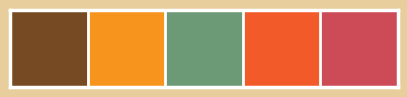

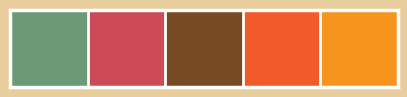

In [23]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#E8CE9D","figure.facecolor":"#E8CE9D","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

# palette = ["#432C0A","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette = ["#764a23","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]

sns.palplot(sns.color_palette(palette))
sns.palplot(sns.color_palette(palette_cmap))
plt.show()

#### Gender In The Dataset

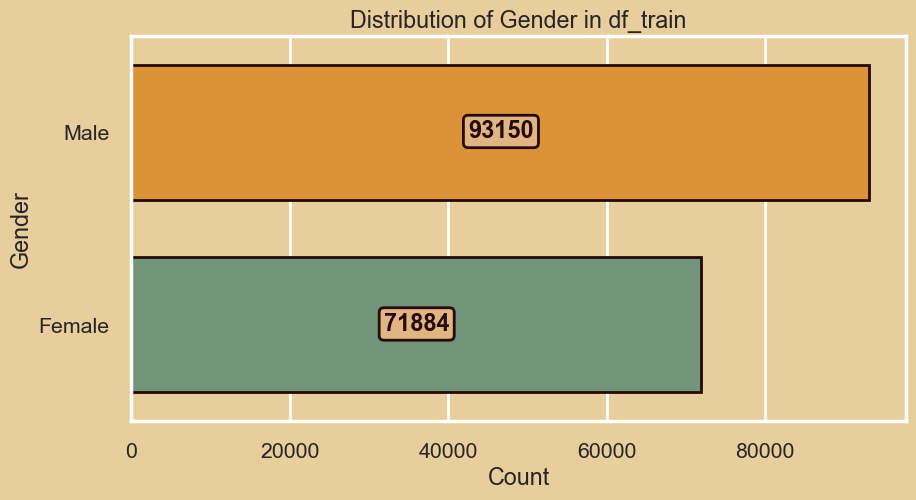

In [25]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Gender", data=df_train, palette=palette[1:3], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Gender in df_train")
plt.xlabel("Count")
plt.ylabel("Gender")

plt.show()

#### Geography In The Dataset

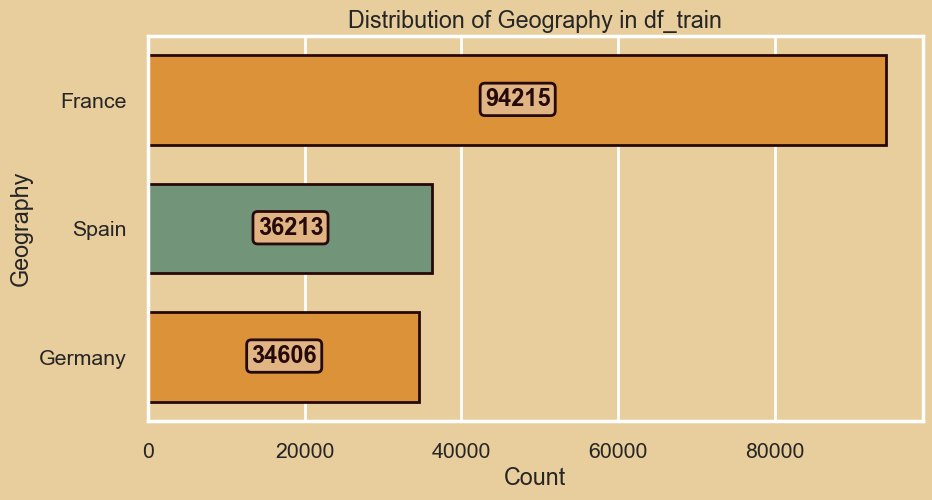

In [27]:
fig = plt.figure(figsize=(10, 5))


p = sns.countplot(y="Geography", data=df_train, palette=palette[1:3], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Geography in df_train")
plt.xlabel("Count")
plt.ylabel("Geography")

plt.show()

#### Tenure In The Dataset

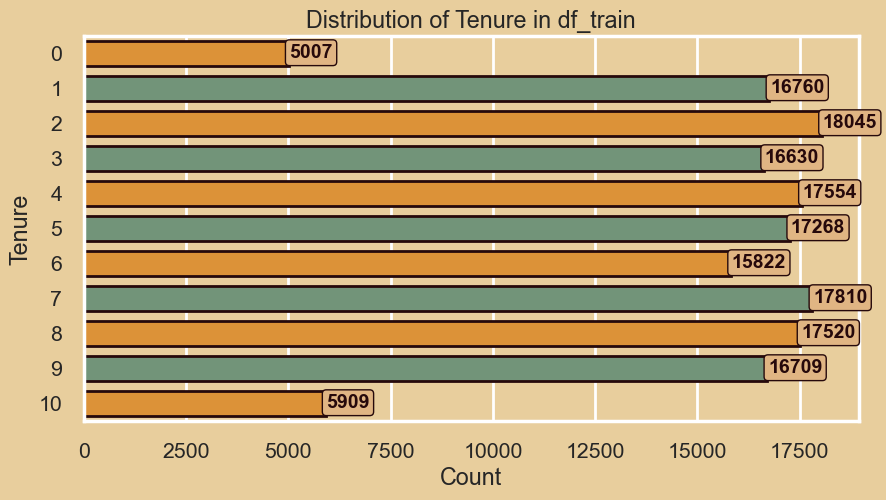

In [28]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Tenure", data=df_train, palette=palette[1:3], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="edge", color='#26090b', fontsize=14, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 1, "alpha": 1})

plt.title("Distribution of Tenure in df_train")
plt.xlabel("Count")
plt.ylabel("Tenure")

plt.show()

#### Number Of Products In The Dataset

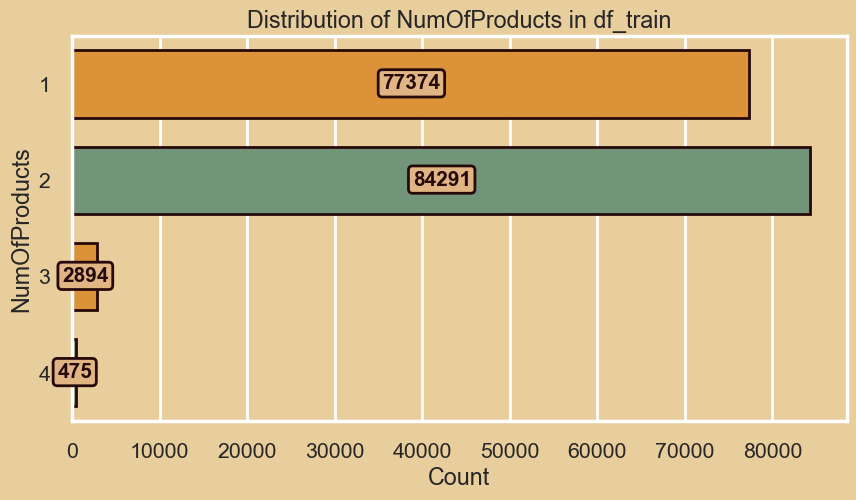

In [29]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="NumOfProducts", data=df_train, palette=palette[1:3]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=15, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of NumOfProducts in df_train")
plt.xlabel("Count")
plt.ylabel("NumOfProducts")

plt.show()

#### Customer Having Credit Card In The Dataset

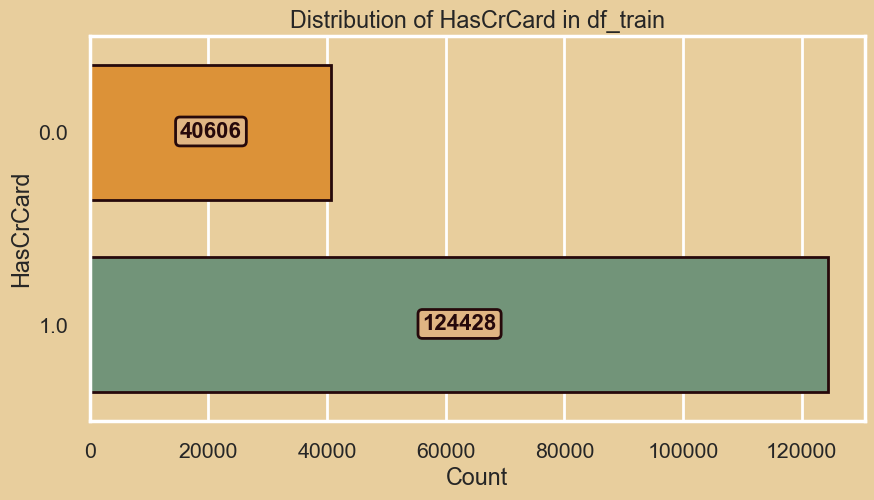

In [31]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="HasCrCard", data=df_train, palette=palette[1:3]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=16, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of HasCrCard in df_train")
plt.xlabel("Count")
plt.ylabel("HasCrCard")

plt.show()

#### Active Customers In The Dataset

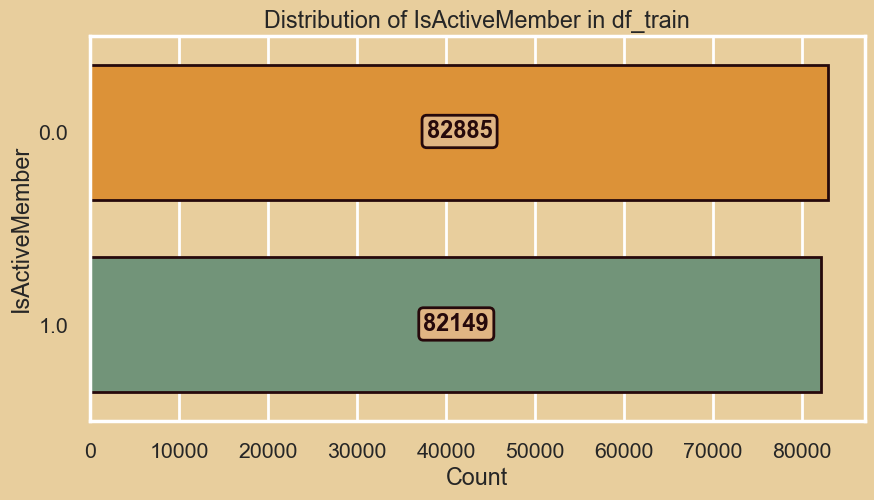

In [32]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="IsActiveMember", data=df_train, palette=palette[1:3], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of IsActiveMember in df_train")
plt.xlabel("Count")
plt.ylabel("IsActiveMember")

plt.show()

#### Exited In The Dataset

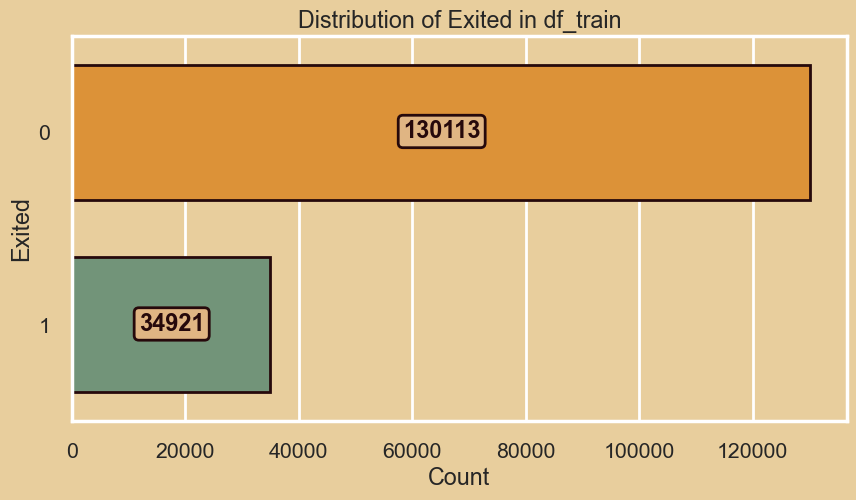

In [34]:
fig = plt.figure(figsize=(10, 5))


p = sns.countplot(y="Exited", data=df_train, palette=palette[1:3], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Exited in df_train")
plt.xlabel("Count")
plt.ylabel("Exited")

plt.show()

#### Credit Score In The Dataset

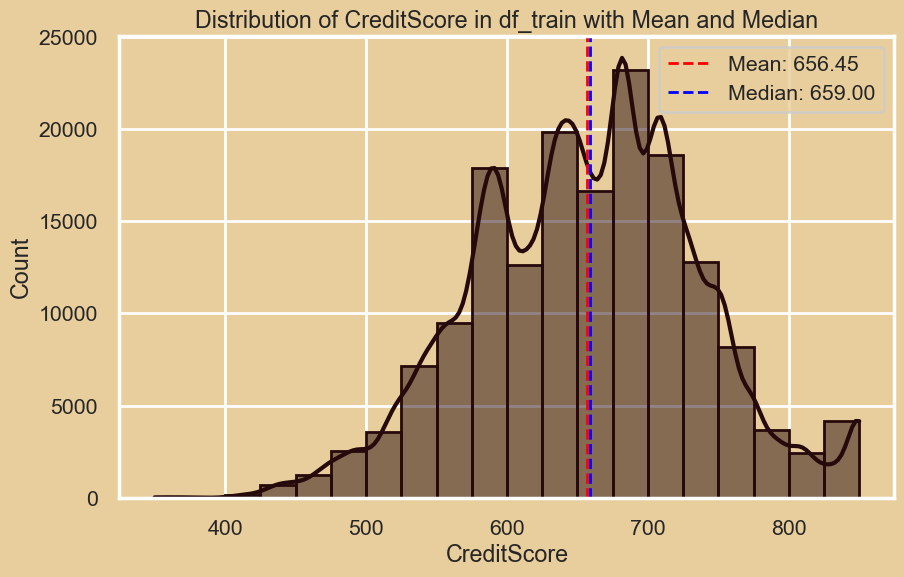

In [35]:
# Create a histogram for the "CreditScore" column with specified colors
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=df_train, x="CreditScore", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = df_train["CreditScore"].mean()
median_value = df_train["CreditScore"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of CreditScore in df_train with Mean and Median")
plt.xlabel("CreditScore")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()

#### Age In The Dataset

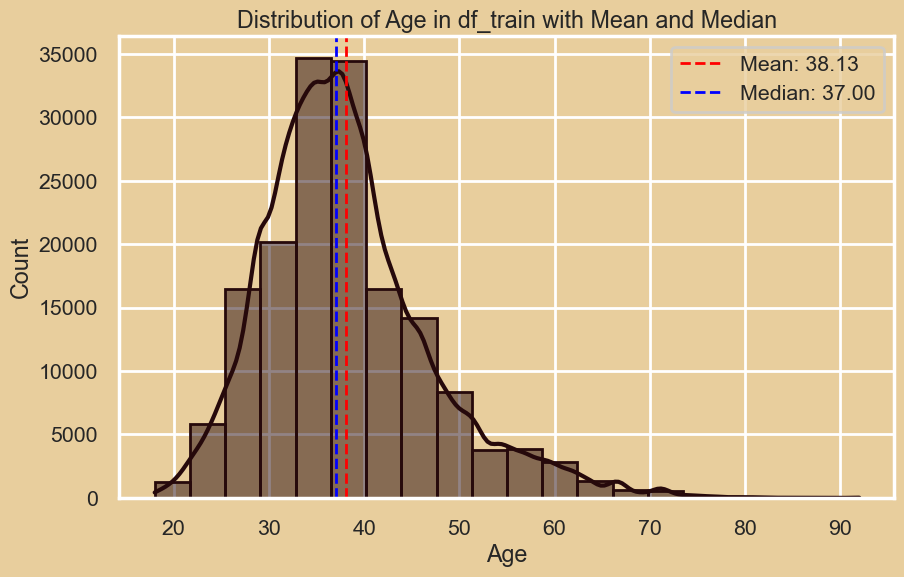

In [36]:
# Create a histogram for the "Age" column with specified colors
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=df_train, x="Age", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = df_train["Age"].mean()
median_value = df_train["Age"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of Age in df_train with Mean and Median")
plt.xlabel("Age")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()

#### Balance In The Dataset

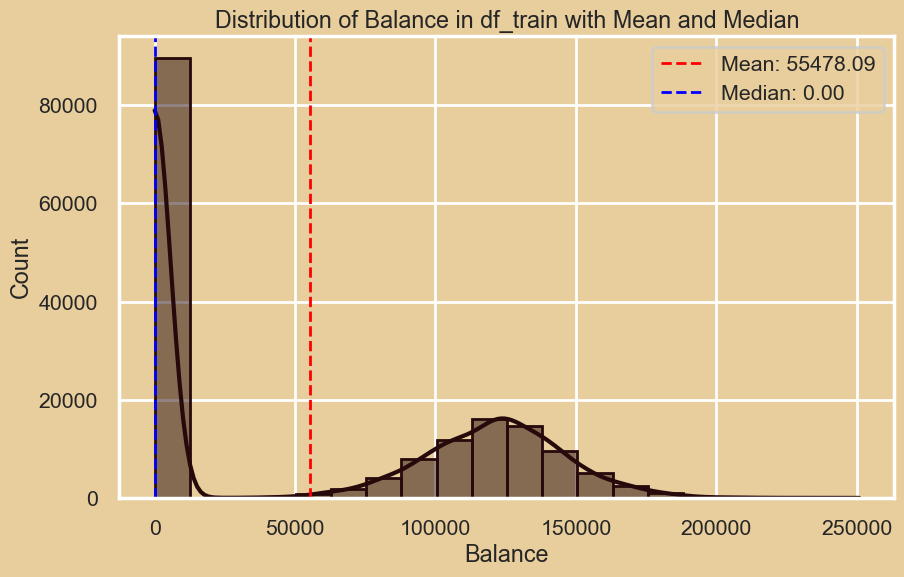

In [37]:
# Create a histogram for the "Balance" column with specified colors
fig= plt.figure(figsize=(10, 6))


histplot = sns.histplot(data=df_train, x="Balance", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = df_train["Balance"].mean()
median_value = df_train["Balance"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of Balance in df_train with Mean and Median")
plt.xlabel("Balance")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()

#### Estimated Salary In The Dataset

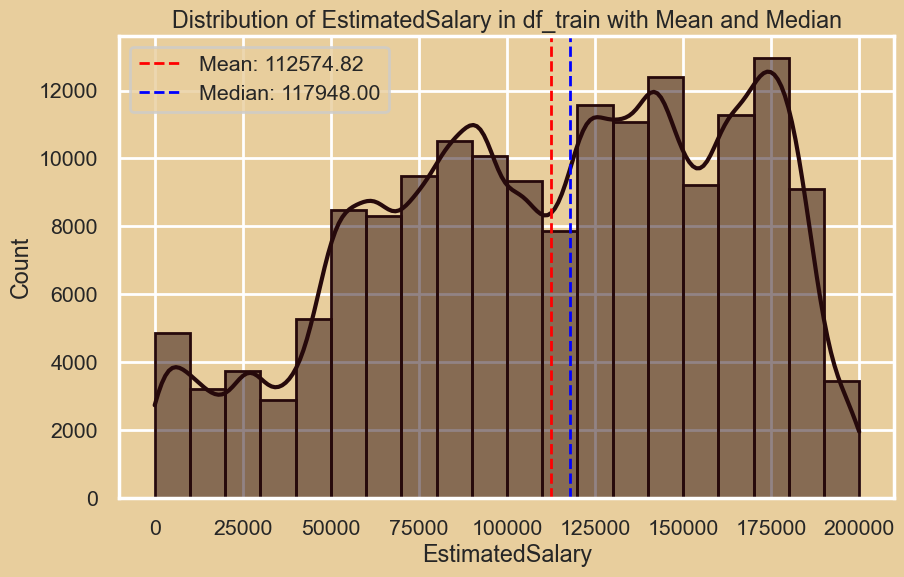

In [38]:
# Create a histogram for the "EstimatedSalary" column with specified colors
fig = plt.figure(figsize=(10, 6))


histplot = sns.histplot(data=df_train, x="EstimatedSalary", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = df_train["EstimatedSalary"].mean()
median_value = df_train["EstimatedSalary"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution of EstimatedSalary in df_train with Mean and Median")
plt.xlabel("EstimatedSalary")
plt.ylabel("Count")

# Show legend
plt.legend()

plt.show()

#### Countplot by Target

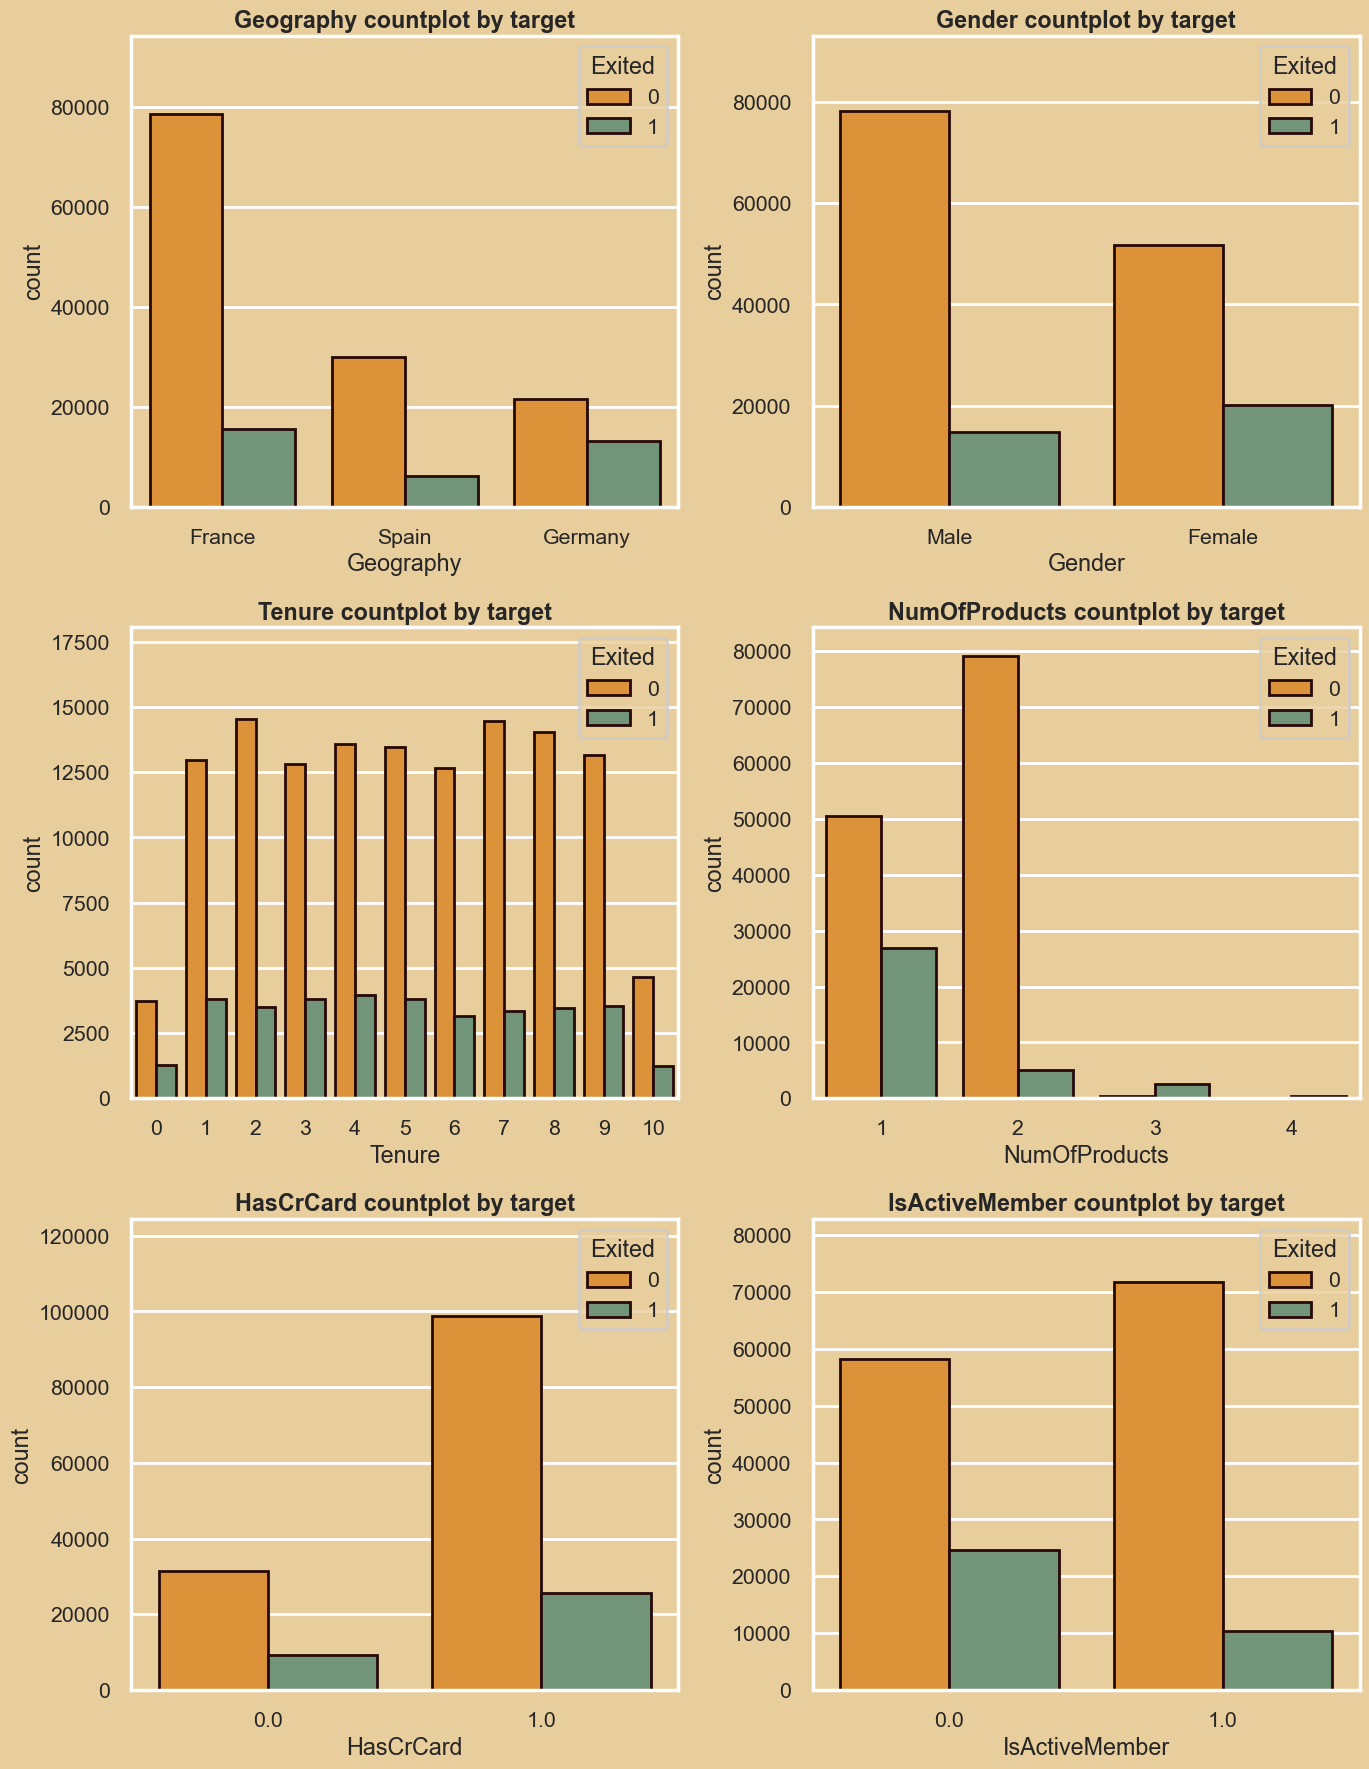

In [40]:
cat_cols = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']

num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

target = 'Exited'
fig = plt.figure(figsize=(14, len(cat_cols)*3))

# background_color = 'grey'
for i, col in enumerate(cat_cols):
    
    plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue=target, data=df_train, palette=palette[1:3], color='#26090b', edgecolor='#26090b')
    plt.title(f"{col} countplot by target", fontweight = 'bold')
    plt.ylim(0, df_train[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()